In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy


Cargo datasets de train, test, y las clases fine (100) y coarse (20).

Divido por 255 para normalizar el RGB a algo entre 0.0 y 1.0

In [3]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")
y_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [4]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)

In [5]:
indices_train = np.arange(len(x_train))
np.random.shuffle(indices_train)

x_train = x_train[indices_train]
y_train = y_train[indices_train]

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
%matplotlib inline

## preprocessing & augmentation

In [7]:
from imgaug import augmenters as iaa
import imgaug as ia
from keras.utils import to_categorical
import random

np.bool = np.bool_

2024-06-20 01:49:00.016624: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 01:49:00.016760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 01:49:00.298408: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


> 

In [8]:
train_images = x_train.astype('float32')/255
test_images = x_test.astype('float32')/255

# train_labels = to_categorical(y_train)
train_labels = y_train

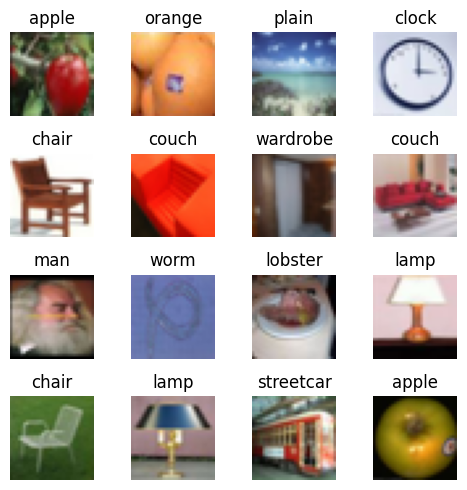

In [9]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(train_images[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
seq = iaa.Sequential([ 
    iaa.Fliplr(1.0), #horizontal mirror, p=1
    iaa.Affine(rotate=(-25,25)), # random degree

    iaa.SomeOf((2, 5),
        [
            iaa.Affine(translate_px={"x": (-5, 5)}),
            iaa.Affine(translate_px={"y": (-5, 5)}),
            iaa.Affine(shear=(-2, 2),mode = ['symmetric','wrap']),#48
            iaa.Affine(scale={"x": (0.90, 1.10), "y": (0.90, 1.10)}),

            iaa.CropAndPad(px=(-2, 2),sample_independently=True,pad_mode=["constant", "edge"]),
    
            iaa.Add((-0.15, 0.15), per_channel=0.5),
            iaa.Multiply((0.95, 1.15), per_channel=0.5),

            iaa.LinearContrast((0.8, 1.4)),
            iaa.Cutout(fill_mode="gaussian", nb_iterations=(1, 4), size=0.10),
        ],random_order=True)
],random_order=True)

In [11]:
aug_test = seq.augment_images(images=train_images[:1000])

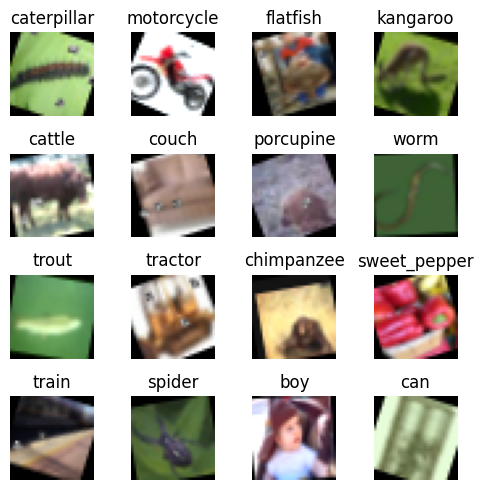

In [12]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 1000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(aug_test[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train_images_aug1 = seq.augment_images(train_images)
train_images_aug2 = seq.augment_images(train_images)
train_images_aug3 = seq.augment_images(train_images)
train_images_aug4 = seq.augment_images(train_images)

In [ ]:
# train_images_aug2 = seq.augment_images(train_images)

In [ ]:
# train_images_aug3 = seq.augment_images(train_images)

In [ ]:
train_images_aug_all = []
train_images_aug_all.extend(train_images)
train_images_aug_all.extend(train_images_aug1)
train_images_aug_all.extend(train_images_aug2)
train_images_aug_all.extend(train_images_aug3)
train_images_aug_all.extend(train_images_aug4)

In [ ]:
train_labels_aug_all = []
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)

In [ ]:
print(len(train_images_aug_all))
print(len(train_labels_aug_all))

In [13]:
train_images_final = []
train_labels_final = []

In [ ]:
# train_images_final = train_images
# train_labels_final = train_labels

In [ ]:
train_images_final = train_images_aug_all
train_labels_final = train_labels_aug_all

combined = list(zip(train_images_aug_all, train_labels_aug_all))
random.shuffle(combined)

train_images_final[:], train_labels_final[:] = zip(*combined)

In [ ]:
train_images_final = np.asarray(train_images_final)
train_labels_final = np.asarray(train_labels_final)

In [14]:
# with open('train_images_final.pkl', 'wb') as f:
#     pickle.dump(train_images_final, f)

# with open('train_labels_final.pkl', 'wb') as f:
#     pickle.dump(train_labels_final, f)
    
    
    
with open('train_images_final.pkl', 'rb') as f:
    train_images_final = pickle.load(f)

with open('train_labels_final.pkl', 'rb') as f:
    train_labels_final = pickle.load(f)

In [15]:
print(train_images_final.shape)
print(train_labels_final.shape)

(250000, 32, 32, 3)
(250000,)


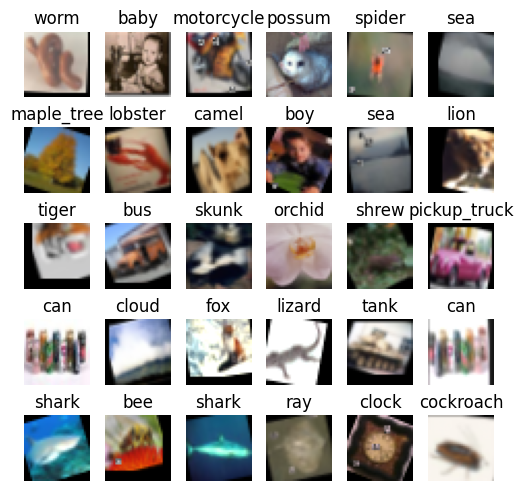

In [16]:
plt.figure(figsize=(5, 5))
for i in range(30):
    rand_num = np.random.randint(0, 250000)
    cifar_img = plt.subplot(5, 6, i + 1)
    plt.imshow(train_images_final[rand_num])
 
    plt.title(labels_fine[train_labels_final[rand_num]]) 
    plt.axis('off')

plt.tight_layout()
plt.show()

## CNNModel

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import collections

In [39]:
num_epochs = 50
batch_size = 512
base_lr = 0.001

In [19]:
model = Sequential()

# -------------------

# # CNN
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same', input_shape=(32,32,3)))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# # Clasificador MLP
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(100, activation='softmax'))

# -------------------

# model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,3)))
# model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu') )
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# # Increased depth to the Conv2D layers, improving the complexity of the features learned
# model.add(Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
# model.add(Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
# model.add(Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# # Depth further increased for the final Conv2D layers
# model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
# model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
# model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(256, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(100, activation='softmax'))

# -------------------

model.add(Conv2D(32, (3, 3), padding='same', activation='swish', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), padding='same', activation='swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='swish'))
model.add(Conv2D(64, (3, 3), padding='same', activation='swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), padding='same', activation='swish'))
model.add(Conv2D(128, (3, 3), padding='same', activation='swish'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(512, activation='swish'))
# model.add(Dense(256, activation='swish'))
model.add(Dropout(0.5))
# model.add(Dense(256, activation='swish'))
# model.add(Dense(128, activation='swish'))
# model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

# -------------------

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=base_lr), metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        51,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,387,396 (5.29 MB)

 Trainable params: 1,387,396 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5,
    min_delta=0.001,
)

In [21]:
mc = ModelCheckpoint(
    ".weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [22]:
es = EarlyStopping(
    monitor = "val_accuracy",
    min_delta=0.001,
    patience = 10, 
    verbose = 1,
    restore_best_weights = True,
)

In [23]:
train_labels_final_tweak = to_categorical(train_labels_final)
print(train_labels_final_tweak.shape)
print(train_images_final.shape)

(250000, 100)
(250000, 32, 32, 3)


In [26]:
history = model.fit(x=train_images_final, y=train_labels_final_tweak, batch_size=batch_size, epochs=num_epochs, validation_split=0.2, callbacks=[rlrop, es, mc])

Epoch 1/50
  2/391 ━━━━━━━━━━━━━━━━━━━━ 26s 67ms/step - accuracy: 0.0117 - loss: 4.6051   

I0000 00:00:1718848291.046230     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718848291.065196     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.0708 - loss: 4.1487

W0000 00:00:1718848317.289146     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718848319.571861     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.21538, saving model to .weights.h5
391/391 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.0709 - loss: 4.1480 - val_accuracy: 0.2154 - val_loss: 3.2818 - learning_rate: 0.0010
Epoch 2/50
  1/391 ━━━━━━━━━━━━━━━━━━━━ 25s 67ms/step - accuracy: 0.1855 - loss: 3.4388

W0000 00:00:1718848323.315203     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2072 - loss: 3.3116
Epoch 2: val_accuracy improved from 0.21538 to 0.30578, saving model to .weights.h5
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.2073 - loss: 3.3113 - val_accuracy: 0.3058 - val_loss: 2.8209 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2702 - loss: 2.9688
Epoch 3: val_accuracy improved from 0.30578 to 0.35604, saving model to .weights.h5
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2702 - loss: 2.9687 - val_accuracy: 0.3560 - val_loss: 2.5717 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3101 - loss: 2.7536
Epoch 4: val_accuracy improved from 0.35604 to 0.39598, saving model to .weights.h5
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.3101 - loss: 2.7535 - val_accuracy: 0.3960 - val_loss: 2.3776 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.34

In [27]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [28]:
all_history = collections.defaultdict(dict)

In [29]:
all_history['case_1_train'] = history.history

In [30]:
print('Train loss:', all_history['case_1_train']['loss'][-1])
print('Train acc:', all_history['case_1_train']['accuracy'][-1])
print('Validation loss:', all_history['case_1_train']['val_loss'][-1])
print('Validation acc:', all_history['case_1_train']['val_accuracy'][-1])

Train loss: 1.56362783908844
Train acc: 0.5616850256919861
Validation loss: 1.3038606643676758
Validation acc: 0.6371399760246277


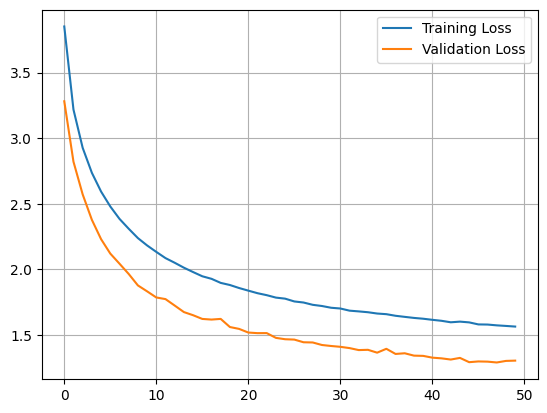

In [31]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()

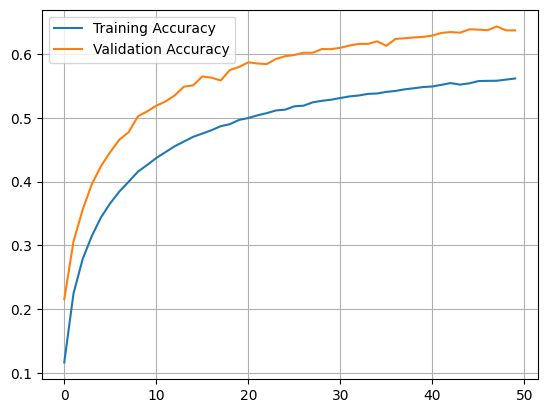

In [32]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.grid()
plt.legend()

In [33]:
test_images_aux = test_images

In [34]:
predictions = model.predict(test_images_aux).argmax(axis=1)

 92/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

W0000 00:00:1718849187.543179     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


W0000 00:00:1718849189.132826     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [35]:
print(predictions.shape)
print(predictions[1])

(10000,)
33


Some predictions:


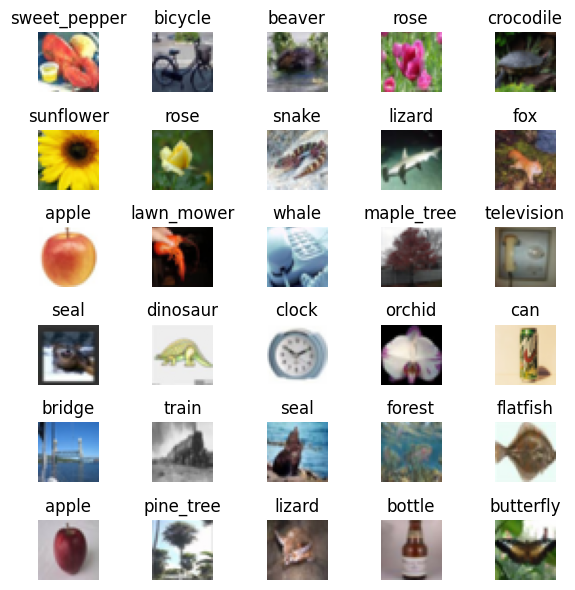

In [36]:
print("Some predictions:")

plt.figure(figsize=(6, 6))
for i in range (30):
  rand_num = np.random.randint(0, 10000)
  cifar_img = plt.subplot(6,5, i+1)
  plt.imshow(test_images_aux[rand_num])
  plt.title(labels_fine[predictions[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [37]:
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"
df.head()
df.to_csv("submission.csv")